## PINN to Approximate Solution of ODEs
Pde for solving Poisson Equation T''(x)+T'(x)-T(x)=0 on x ϵ [0,1]. 

Boundary conditions: T(0)=1, T'(1)=0;

In [10]:
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

import time

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [11]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons, retrain_seed=42):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dimension, 32) 
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32, output_dimension) 
        self.tanh = nn.Tanh()
        self._init_weights()
    #initialize the network weights
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='tanh')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

In [12]:
class PINNTrainer:
    def __init__(self, n_int_, n_sb_, n_nb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_nb = n_nb_
        self.T0 = 1   # Boundary condition at x = 0
        self.domain_extrema = torch.tensor([[0, 1]])  # space dimension (x in [0, 1])

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance the role of data and PDE
        self.alpha= 6

        # Neural network to approximate the solution of the ODE
        self.approximate_solution = NeuralNet(input_dimension=1,
                                              output_dimension=1,
                                              n_hidden_layers=3,
                                              neurons=20)

        self.optimizer = optim.LBFGS(self.approximate_solution.parameters(),
                                      lr=0.01,
                                      max_iter=1000,
                                      max_eval=50000,
                                      history_size=150,
                                      line_search_fn=None,
                                      tolerance_change=1.0 * np.finfo(float).eps)

        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.02)

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # we assemble the datasets of boundary and interior nodes
        self.training_set_sb, self.training_set_int, self.training_set_nb = self.assemble_datasets()

    def add_spatial_boundary_points(self): #boundary points Dirichlet condition
        # x = 0 (Dirichlet boundary at x = 0 with T(0) = T0)
        input_sb= torch.zeros((self.n_sb, 1))
        output_sb= torch.full((self.n_sb, 1), self.T0)  # T(x=0) = T0
      
        return input_sb, output_sb

    def add_neumann_boundary_points(self): # boundary points for Neumann boundary points
        input_nb_x1 = torch.ones((self.n_nb, 1))
        output_nb_x1 = torch.zeros((self.n_nb, 1))  # Neumann condition dT/dx = 0 at x = 1

        return input_nb_x1, output_nb_x1

    # Interior points (for the PDE residual)
    def add_interior_points(self):
        input_int = self.soboleng.draw(self.n_int) * (self.domain_extrema[0, 1] - self.domain_extrema[0, 0]) + self.domain_extrema[0, 0]
        output_int = torch.full((self.n_int, 1), self.T0) #this is just a placeholder as we only need to calculate the residual for the loss of interior points
        return input_int, output_int

    # function yo assemble datasets for the boundary and interior points
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # Dirichellt boundary points
        input_int, output_int = self.add_interior_points()         # Interior points
        input_nb, output_nb = self.add_neumann_boundary_points()   # Neumann boundary points

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2 * self.space_dimensions * self.n_sb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)
        training_set_nb = DataLoader(torch.utils.data.TensorDataset(input_nb, output_nb), batch_size=self.n_nb, shuffle=False)
        
        return training_set_sb, training_set_int, training_set_nb

    # Apply ALL boundary conditions
    def apply_boundary_conditions(self, input_sb, input_nb):
        input_nb.requires_grad_(True)
        
        #  Dirichlet boundary points
        predictions_sb = self.approximate_solution(input_sb)
        
        #  Neumann boundary points
        predictions_nb = self.approximate_solution(input_nb)
        grad_nb = torch.autograd.grad(predictions_nb.sum(), input_nb, create_graph=True)[0]
        grad_nb_x = grad_nb[:, 0]  # Derivative with respect to x

        return predictions_sb, grad_nb_x

    # Compute the PDE residuals of the interios points
    def compute_pde_residual(self, input_int):
        input_int.requires_grad_(True)
        predictions = self.approximate_solution(input_int)

 
        grad_T = torch.autograd.grad(predictions.sum(), input_int, create_graph=True)[0]
        grad_T_x = grad_T[:, 0]  # first derivative with respect to x
        grad_T_xx = torch.autograd.grad(grad_T_x.sum(), input_int, create_graph=True)[0][:, 0] #second derivative
        # Compute the residual of the ODE f''(x) + f'(x) - f(x) = 0
        residual = grad_T_xx + grad_T_x - predictions.squeeze()
        return residual

    # the TOTAL loss
    def compute_loss(self, inp_train_sb, train_sb, inp_train_nb, inp_train_int, verbose=True):
        # Apply boundary conditions
        pred_sb, neumann_loss = self.apply_boundary_conditions(inp_train_sb, inp_train_nb)

        residual_int = self.compute_pde_residual(inp_train_int)

        # Losses
        loss_sb = torch.mean((train_sb - pred_sb) ** 2)  # Dirichlet boundary loss
        loss_neumann = torch.mean((neumann_loss) ** 2)  # Neumann boundary loss
        loss_int = torch.mean(residual_int ** 2)  # PDE residual loss

        # Combine losses
        total_loss = self.alpha * (loss_sb + loss_neumann) + loss_int
        """
        if verbose:
            print("Loss - Boundary:", round(loss_sb.item(), 4),
                  "| Neumann:", round(loss_neumann.item(), 4),
                  "| PDE:", round(loss_int.item(), 4))
        """
        return total_loss
    def fit(self, num_epochs, verbose=True):
        history = []

        for epoch in range(num_epochs):
            if verbose:
                print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_int, u_train_int), (inp_train_nb, u_train_nb)) in enumerate(zip(self.training_set_sb, self.training_set_int, self.training_set_nb)):
                def closure():
                    self.optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_nb, inp_train_int, verbose=verbose)
                    loss.backward()
                    history.append(loss.item())
                    return loss
                self.optimizer.step(closure=closure)

            if verbose:
                print('Epoch Loss: ', history[-1])

        print('Final Loss: ', history[-1])
        return history

    def plotting(self):
        #exact solution of the problem
        def f(x):
          return 0.2186 * np.exp(0.6180 * x) + 0.7814 * np.exp(-1.6180 * x)

        inputs = self.soboleng.draw(1000)  #inputs of stpatial position

        output = self.approximate_solution(inputs)  # predict the output
        T_pred = output[:, 0]
        
        # Plotting T(x)
        plt.figure(figsize=(4, 3), dpi=150)
        # the predicted solution 
        plt.scatter(inputs[:, 0].detach().numpy(), T_pred.detach().numpy(), label="Predicted $T(x)$", color='blue',s=7)

        # the exact solution
        plt.scatter(inputs[:, 0].detach().numpy(), f(inputs[:, 0].detach().numpy()), label="Exact $T(x)$", color='red',s=7)

        plt.xlabel("x")
        plt.ylabel("T(x)")
        plt.grid(True, which="both", ls=":")
        plt.legend()
        plt.title("Approximate vs Exact Solution for $T(x)$")

        plt.show()



Generating the data points to train the network

torch.Size([3, 1])
torch.Size([20, 1])


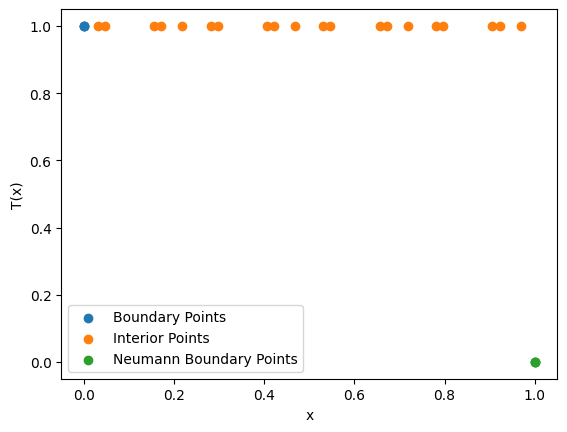

In [13]:
n_int = 20
n_sb = 3
n_nb = 3

# Instantiate the PINNTrainer class
pinn = PINNTrainer(n_int, n_sb, n_nb)

# Plot the input training points.
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()
input_nb, output_nb = pinn.add_neumann_boundary_points()

print(output_sb_.size())
print(output_int_.size())

# Plot the boundary points
plt.scatter(
    input_sb_[:, 0].detach().numpy(),
    output_sb_[:, 0].detach().numpy(),
    label="Boundary Points")

plt.scatter(
    input_int_[:, 0].detach().numpy(),
    output_int_[:, 0].detach().numpy(),
    label="Interior Points")

plt.scatter(
    input_nb[:, 0].detach().numpy(),
    output_nb[:, 0].detach().numpy(),
    label="Neumann Boundary Points")

plt.xlabel("x")
plt.ylabel("T(x)")
plt.legend()
plt.show()

Training the network

################################  0  ################################
Epoch Loss:  7.030860433587804e-05
Final Loss:  7.030860433587804e-05


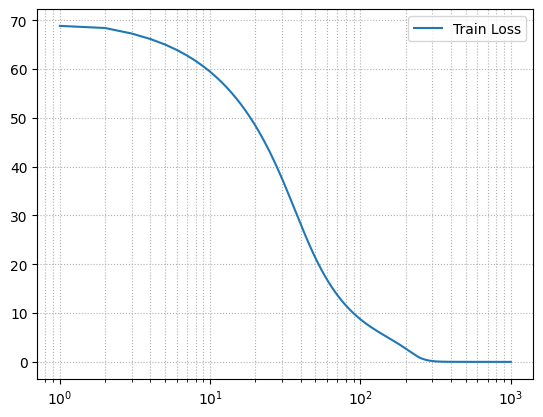

In [14]:
hist = pinn.fit(num_epochs=1, verbose=True)

plt.figure(dpi=100)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

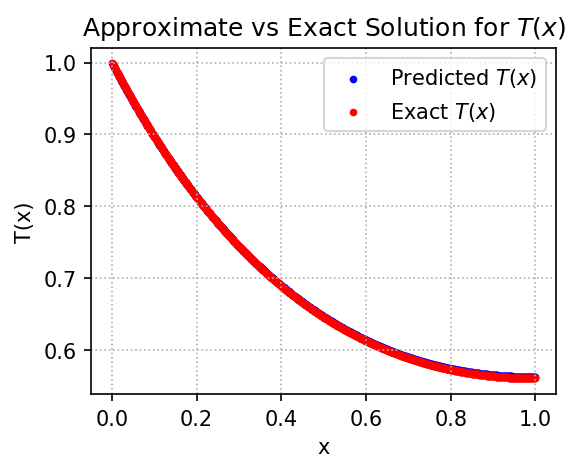

In [15]:
pinn.plotting()